# Run Simulation

In [3]:
import sys
import os
import numpy as np
from numpy.linalg import norm, svd, solve, qr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel
import networkx as nx

import scipy
from scipy.sparse import csr_matrix
from scipy.optimize import linear_sum_assignment

import cvxpy as cp
from cvxpy import Variable
from cvxpy.problems.objective import Minimize
from cvxpy.problems.problem import Problem

sys.path.append("./SpLSI/pycvxcluster/src/")
import pycvxcluster.pycvxclt

from SpLSI import generate_topic_model as gen_model
from SpLSI.utils import *
from SpLSI.spatialSVD import *
from SpLSI import splsi

# from netgraph import Graph
# from netgraph import get_sugiyama_layout

N = 100  # doc length
n = 1000  # number of nodes
p = 30  # vocab size
K = 3  # number of topics
r = 0.05  # heterogeneity parameter
m = 5  # number of neighbors to be considered in weights
phi = 0.1  # weight parameter

# One example of generated data
df, W, A, D = gen_model.generate_data(N, n, p, K, r)
# gen_model.plot_scatter(df)

## Ground Truth W1, W2, W3 (one simulation)

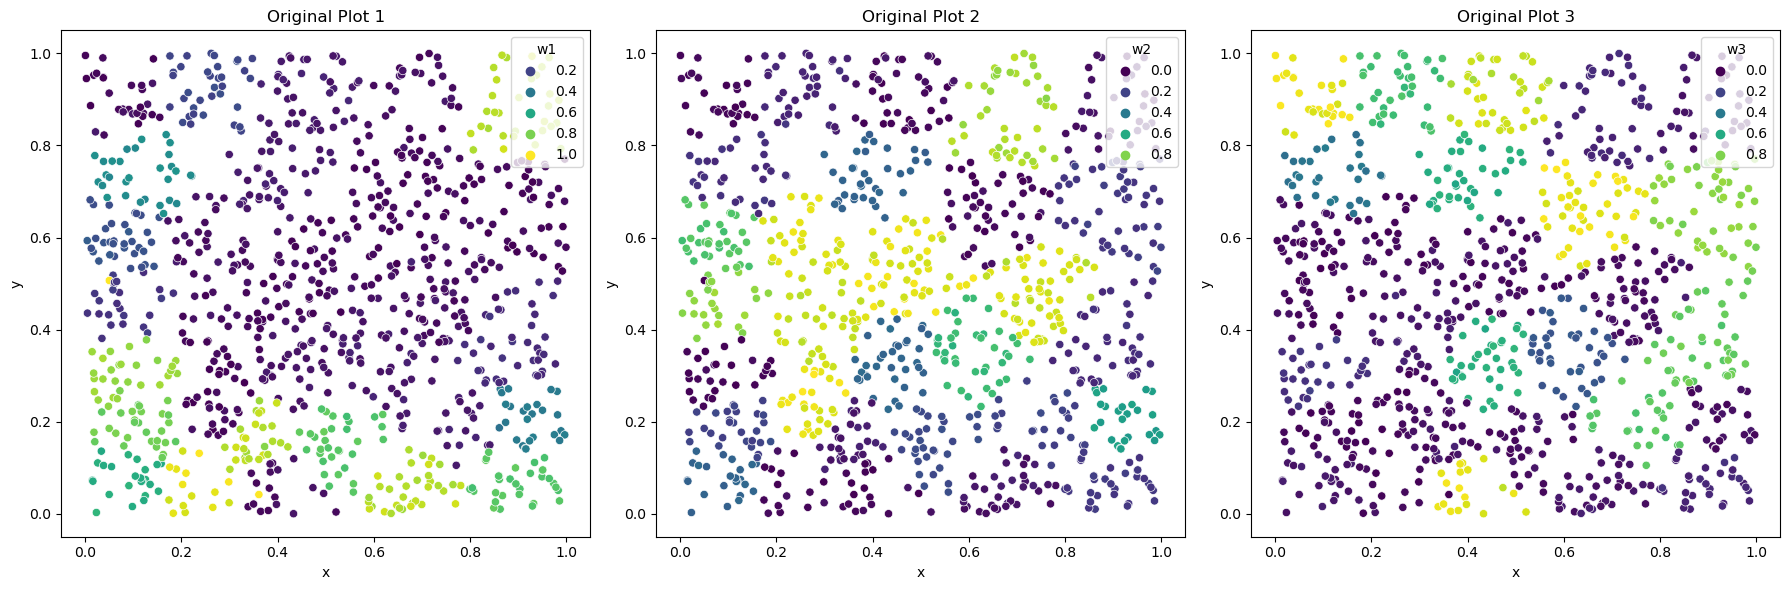

In [2]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for j, ax in enumerate(axes):
    w = W[j, :]
    df[f"w{j+1}"] = w
    sns.scatterplot(x="x", y="y", hue=f"w{j+1}", data=df, palette="viridis", ax=ax)
    ax.set_title(f"Original Plot {j+1}")
plt.tight_layout()
plt.show()

## Run

In [7]:
def run_simul(nsim, N_vals, n=1000, p=30, K=3, r=0.05, m=5, phi=0.1):
    results = []

    for N in N_vals:
        print(f"Running simulation for N={N}...")

        for _ in range(nsim):
            # Generate topic data and graph
            df, W, A, D = gen_model.generate_data(N, n, p, K, r)
            weights = gen_model.generate_weights(df, K, m, phi)

            # Vanilla SVD
            spl_v = splsi.SpLSI(
                lamb_start=0.0001, step_size=1.2, grid_len=50, method="nonspatial"
            )
            spl_v.fit(D, K, df, weights)

            # Spatial SVD (two-step)
            spl_2 = splsi.SpLSI(
                lamb_start=0.0001, step_size=1.2, grid_len=50, step="two-step"
            )
            spl_2.fit(D, K, df, weights)

            # Record [err, acc] for spl_v and spl_2
            P_v = get_component_mapping(spl_v.W_hat.T, W)
            P_2 = get_component_mapping(spl_2.W_hat.T, W)

            W_hat_v = spl_v.W_hat @ P_v
            W_hat_2 = spl_2.W_hat @ P_2
            err_acc_spl_v = [get_F_err(W_hat_v, W), get_accuracy(df, n, W_hat_v)]
            err_acc_spl_2 = [get_F_err(W_hat_2, W), get_accuracy(df, n, W_hat_2)]

            results.append(
                {
                    "N": N,
                    "model1": spl_v,
                    "model2": spl_2,
                    "spl_v_err": err_acc_spl_v[0],
                    "spl_v_acc": err_acc_spl_v[1],
                    "spl_2_err": err_acc_spl_2[0],
                    "spl_2_acc": err_acc_spl_2[1],
                    "spl_2_lambd": spl_2.lamd,
                }
            )
    df_grouped = pd.DataFrame(results)

    return df_grouped

#### In the output messages below, the number of times the message "Error is xxx" is shown corresponds to the number of iterations for Spatial SVD.

In [9]:
simulation_results = run_simul(N_vals=[10, 50, 100, 200, 1000])

Running simulation for N=10...
Running vanilla SVD...
Running SPOC...
Running spatial SVD...
Source node is 553


/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/ssnal.py:339: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/ssnal.py:438: RuntimeWarning: invalid value encountered in scalar divide
  dualinf_ratio = dualinf_hist[itersub] / dualinf_hist[itersub - 1]


Error is 2.2047625636250348
Error is 0.16697965452549116
Error is 0.0011031846770329441
Error is 8.771050456528071e-06
Error is 7.941581199027914e-08
Running SPOC...
Running simulation for N=50...
Running vanilla SVD...
Running SPOC...
Running spatial SVD...
Source node is 645


/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/ssnal.py:339: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/ssnal.py:438: RuntimeWarning: invalid value encountered in scalar divide
  dualinf_ratio = dualinf_hist[itersub] / dualinf_hist[itersub - 1]


Error is 1.6656300304686436
Error is 0.0491171387316278
Error is 0.00012295142066288565
Error is 6.811346290703733e-07
Running SPOC...
Running simulation for N=100...
Running vanilla SVD...
Running SPOC...
Running spatial SVD...
Source node is 778


/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/ssnal.py:339: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/ssnal.py:438: RuntimeWarning: invalid value encountered in scalar divide
  dualinf_ratio = dualinf_hist[itersub] / dualinf_hist[itersub - 1]


Error is 1.3389498847253023
Error is 0.01198798434587664
Error is 3.056106786851314e-05
Error is 1.111541546388236e-07
Running SPOC...
Running simulation for N=200...
Running vanilla SVD...
Running SPOC...
Running spatial SVD...
Source node is 61


/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/ssnal.py:339: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/ssnal.py:438: RuntimeWarning: invalid value encountered in scalar divide
  dualinf_ratio = dualinf_hist[itersub] / dualinf_hist[itersub - 1]


Error is 0.6590911812684977
Error is 0.0030648632424235874
Error is 2.9720091167491316e-07
Running SPOC...
Running simulation for N=1000...
Running vanilla SVD...
Running SPOC...
Running spatial SVD...
Source node is 768


/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/ssnal.py:339: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/jeong-yeojin/Desktop/SpLSI/./SpLSI/pycvxcluster/src/pycvxcluster/algos/ssnal.py:438: RuntimeWarning: invalid value encountered in scalar divide
  dualinf_ratio = dualinf_hist[itersub] / dualinf_hist[itersub - 1]


Error is 0.5736605228553358
Error is 0.0007884061781974686
Error is 9.059639385417984e-09
Running SPOC...


## Plot

In [ ]:
df_melted = pd.melt(
    simulation_results[["spl_v_err", "spl_2_err", "N"]],
    id_vars="N",
    var_name="methods",
    value_name="err",
)
sns.lineplot(x="N", y="err", hue="methods", data=df_melted, marker="o")

In [ ]:
df_melted = pd.melt(
    res[["spl_v_acc", "spl_2_acc", "N"]],
    id_vars="N",
    var_name="methods",
    value_name="acc",
)
sns.lineplot(x="N", y="acc", hue="methods", data=df_melted, marker="o")

In [ ]:
sns.lineplot(x="N", y="spl_2_lambd", data=res, marker="o")